In [76]:
import random
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

random.seed(42)


# History

You are a student looking for an apartment. You found a bank offering a special from government 'Safe Start' loan.

The rules of the promotion are:

The Subsidy: The government pays all the interest costs as long as the NBP reference rate is low (below 2%). In this range, your cost is 0.
The Excess: If the NBP rate rises above 2%, the government stops covering the extra part.
You have to pay the difference, multiplied by a bank's risk factor
You have data on what your friends on this plan have paid in recent months.
You know the cost should be zero below 2%, and rise linearly above it

However, you suspect the bank is cheating on the risk factor.
You want to check if the parameter tying your payments to the NBP excess changed during this period,
indicating the bank is secretly overcharging on the non-subsidized portion

# Switch occurs more gradually

In [77]:
def sigmoid(x:np.ndarray, k: float, x0: float) -> np.ndarray:
    """
    Computes the sigmiod function

    Args:
        x (np.ndarray): The input
        k (float): Steepness of the curve (higher, sharper switch)
        x0 (float): The midpoint of the transition (time tau)
    """
    return 1 / (1 + np.exp(-k * (x - x0)))

# Data generate

In [78]:
def generate_data(n_days: int, tau: int, b1: float, b2: float, noise_std: float, gradual_weight: float = None) -> tuple:
    """
    Generates synthetic data about mortgage payment based on NBP rates.

    Args:
        n_days (int): Number of days
        tau (float): The day the risk factor changes
        b1 (float): Risk factor before the change
        b2 (float): Risk factor after the change
        noise_std (float): Standard deviation of noise
        gradual_weight (float, optional): If provided, simulates a gradual transition

    Returns:
        tuple: (nbp_rates, observed_payments, true_risk_factors)
    """

    # Generate time,actually days index
    idx = np.arange(n_days)

    # Generate NBP rates
    rates = np.random.uniform(0.1, 5, n_days)

    if gradual_weight is None:
        risk_array = np.where(idx < tau, b1, b2) # Where - Return elements chosen from x or y depending on condition.
    else:
        weight = sigmoid(x=idx, k=gradual_weight, x0=tau) # weight is between (0,1)
        risk_array = (1 - weight) * b1 + weight * b2


    deterministic_payment = risk_array * np.maximum(0, rates - 2.0) # Using max to avoid negative values so it more like ReLU

    # Adding gaussian noise
    noise = np.random.normal(loc=0, scale=noise_std, size=n_days)
    noisy_payment = deterministic_payment + noise
    observed_payments = np.maximum(0, noisy_payment)

    return rates, observed_payments, risk_array


In [79]:
def run(rates: np.ndarray, payments: np.ndarray):
    """
    Defines and runs the PyMC model

    Args:
        rates (np.ndarray): Observed NBP rates
        payments (np.ndarray): Observed payments.

    Returns:
        The posterior samples
    """
    if len(rates) != len(payments):
        raise ValueError("Shape missmatch between rates and payments")

    with pm.Model() as model:
        # b is a slope in my history is like risk factor, we can define two possible risk factors

        # The factor of risk before the change (Polite Bank)
        b_1 = pm.Uniform("b_1", lower=0, upper=10) # (0, 10) because payment can increase for example up to 10%

        # The factor after the change (Greedy Bank)
        b_2 = pm.Uniform("b_2", lower=0, upper=10)

        # Day of the change
        tau = pm.DiscreteUniform("tau", lower=0, upper=len(rates) - 1)

        # Indexes of days
        idx = np.arange(len(rates))

        # Switch logic, before tau = use b_1, after tau = use b_2
        b = pm.math.switch(tau > idx, b_1, b_2)

        # 2% as a threshold
        threshold = 2

        # Payment can't be negative so
        excess_rate = pm.math.maximum(0, rates - threshold)

        # Assuming that all my points are > 2%
        mean_payment = pm.Deterministic("expected_payment", b * excess_rate)
        sigma_e = pm.Uniform("sigma_e", lower=0.1, upper=10) # (0.1, 10) because it can change payment due to some errors, hidden fees
        payment = pm.Normal("payment", mu=mean_payment, sigma=sigma_e, observed=observed_payments)

        idata = pm.sample(2000, tune=2500)

        return idata


In [80]:
# Define the TRUE part of the story
NUMBER_OF_DAYS = 30
TAU = 15 # This is the moment when bank secretly changed the risk factor (from honest to greedy)
B1 = 1
B2 = 5
NOISE_STD = 0.1

# Generate the fake data
rates, observed_payments, risk_array = generate_data(NUMBER_OF_DAYS, TAU, B1, B2, NOISE_STD)

# Visualization of fake data

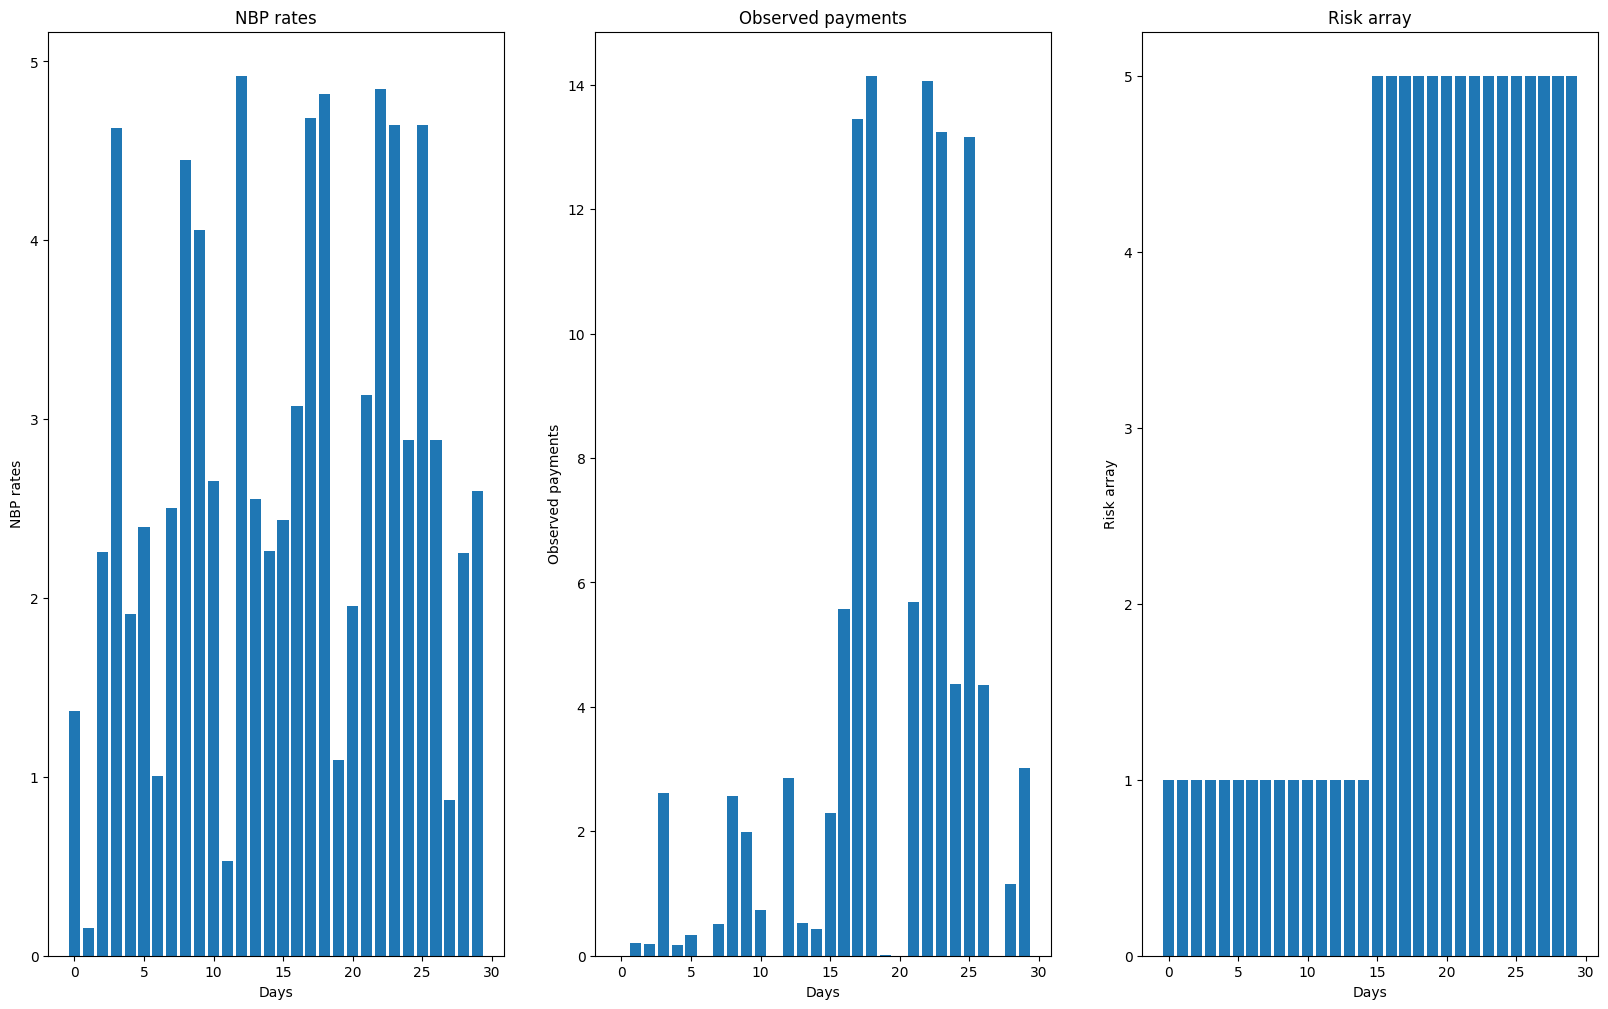

In [81]:
days = np.arange(NUMBER_OF_DAYS)
fig, ax = plt.subplots(1, 3, figsize=(20, 12))

ax[0].bar(days, rates, label="NBP rates")
ax[0].set_title("NBP rates")
ax[0].set_xlabel("Days")
ax[0].set_ylabel("NBP rates")

ax[1].bar(days, observed_payments, label="Observed payments")
ax[1].set_title("Observed payments")
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Observed payments")

ax[2].bar(days, risk_array, label="Risk array")
ax[2].set_title("Risk array")
ax[2].set_xlabel("Days")
ax[2].set_ylabel("Risk array")

plt.show()

# What we will get from a model?

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_1, b_2, sigma_e]
>Metropolis: [tau]


Output()

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 138 seconds.
F:\OneDrive - Politechnika Łódzka\[03] Studies\[02] Second Term\[04] Metody probabilistycznej analizy danych\Laboratorium\Workplace_PyCharm\.venvPC\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
F:\OneDrive - Politechnika Łódzka\[03] Studies\[02] Second Term\[04] Metody probabilistycznej analizy danych\Laboratorium\Workplace_PyCharm\.venvPC\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
F:\OneDrive - Politechnika Łódzka\[03] Studies\[02] Second Term\[04] Metody probabilistycznej analizy danych\Laboratorium\Workplace_PyCharm\.venvPC\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarni

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_1       1.000  0.022   0.958    1.040        0.0      0.0    5310.0   
b_2       4.994  0.017   4.963    5.026        0.0      0.0    6280.0   
tau      15.000  0.000  15.000   15.000        0.0      NaN    8000.0   
sigma_e   0.111  0.010   0.100    0.129        0.0      0.0    5003.0   

         ess_tail  r_hat  
b_1        4851.0    1.0  
b_2        5243.0    1.0  
tau        8000.0    NaN  
sigma_e    3245.0    1.0  


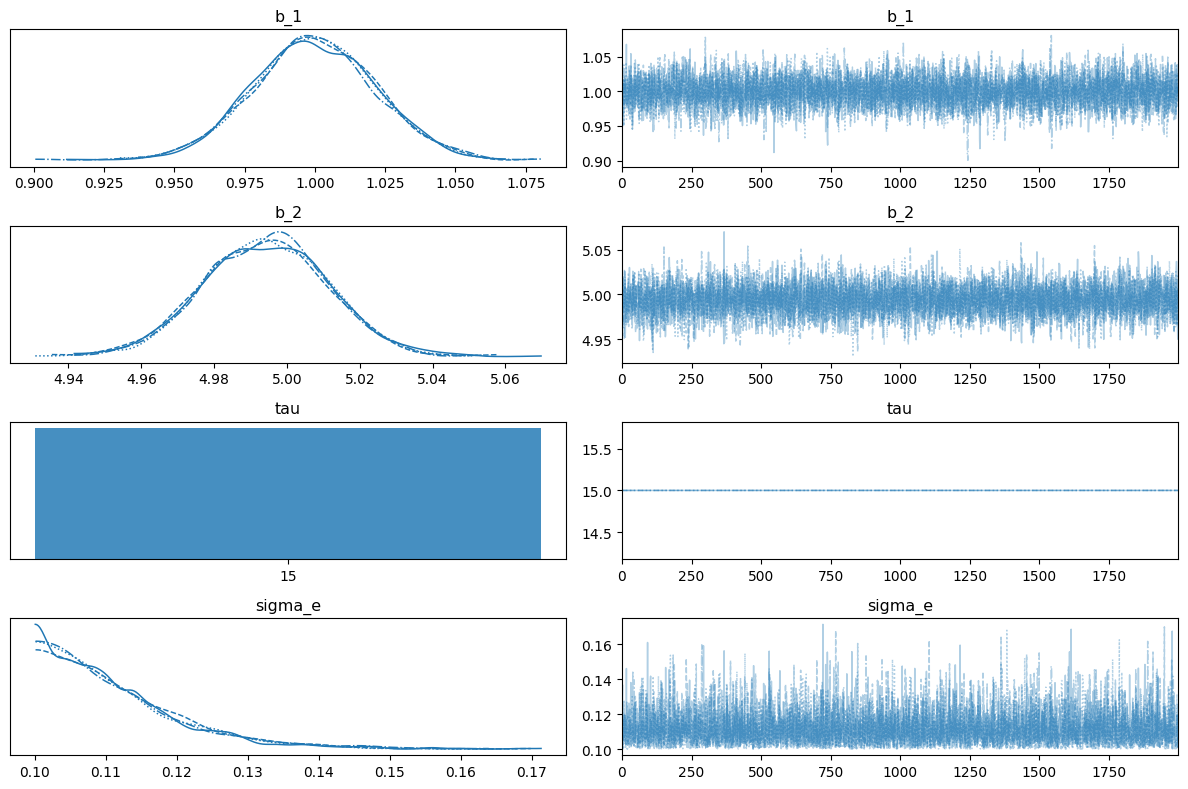

In [82]:
trace = run(rates=rates, payments=observed_payments)
summary = az.summary(trace, var_names=["b_1", "b_2", "tau", "sigma_e"])
print(summary)

az.plot_trace(trace, var_names=["b_1", "b_2", "tau", "sigma_e"])
plt.tight_layout()
plt.show()


# Diffrence between the two part becomes less pronounced
So in our case this is just smaller value of risk factory after bank want to fool us

In [83]:
# Define the TRUE part of the story
NUMBER_OF_DAYS = 30
TAU = 15 # This is the moment when bank secretly changed the risk factor (from honest to greedy)
B1 = 1
B2 = 2
NOISE_STD = 0.1

# Generate the fake data
rates, observed_payments, risk_array = generate_data(NUMBER_OF_DAYS, TAU, B1, B2, NOISE_STD)

Text(0, 0.5, 'Risk array')

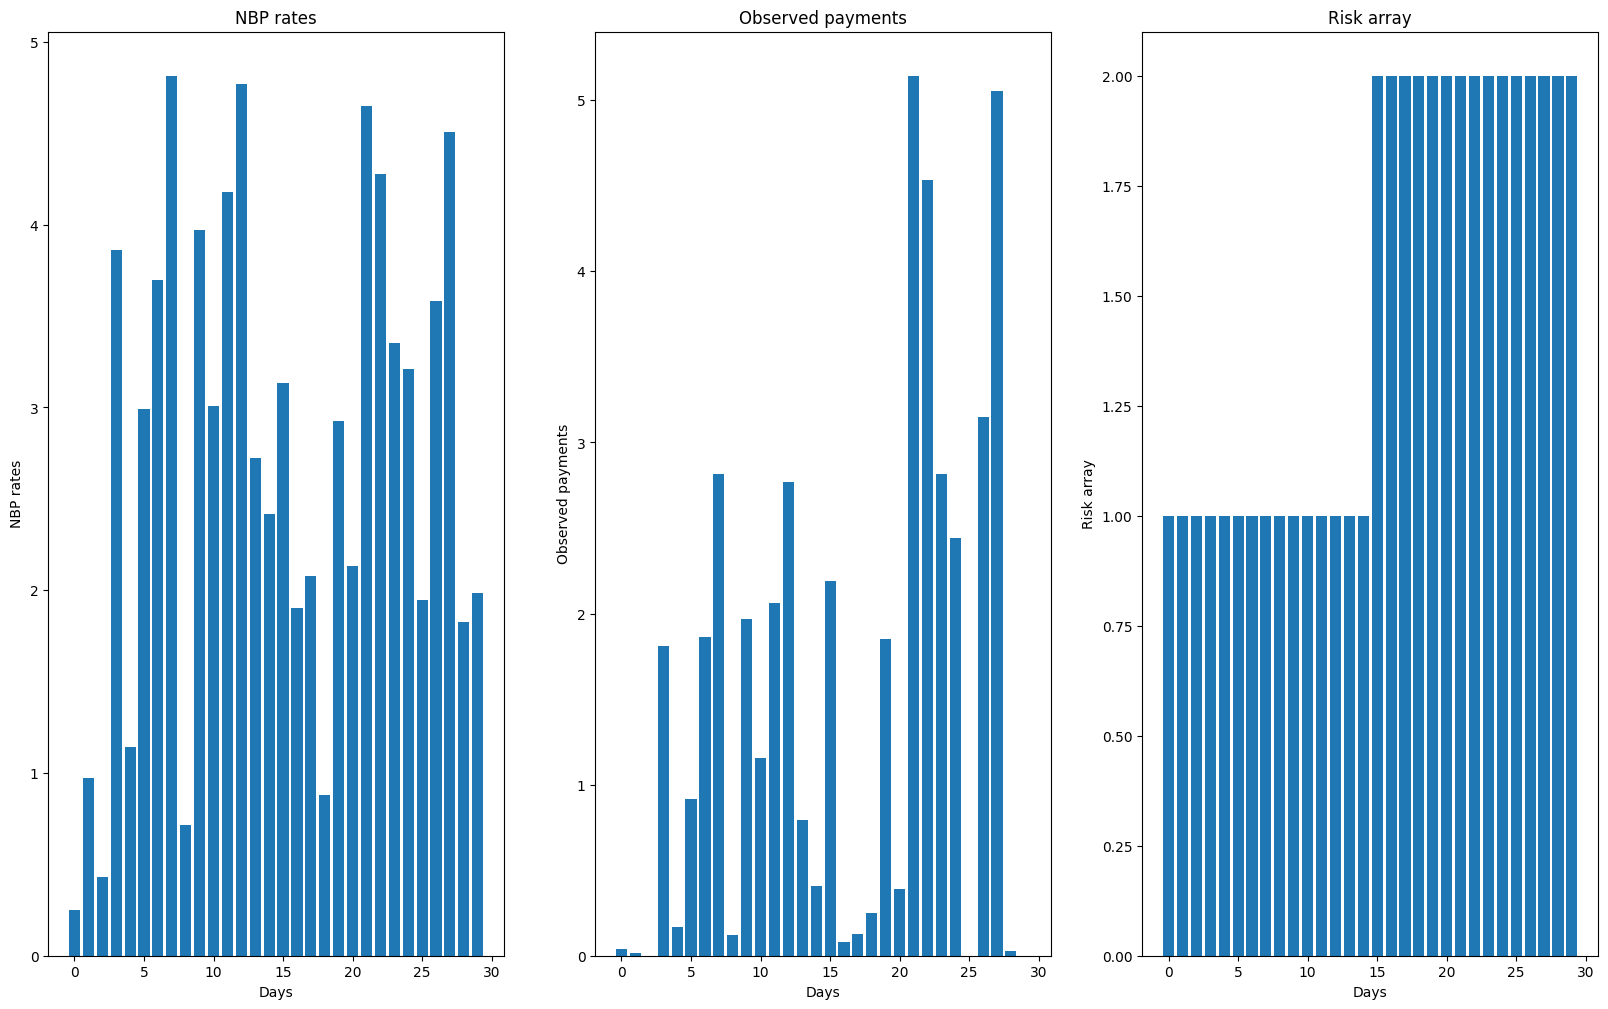

In [84]:
days = np.arange(NUMBER_OF_DAYS)
fig, ax = plt.subplots(1, 3, figsize=(20, 12))

ax[0].bar(days, rates, label="NBP rates")
ax[0].set_title("NBP rates")
ax[0].set_xlabel("Days")
ax[0].set_ylabel("NBP rates")

ax[1].bar(days, observed_payments, label="Observed payments")
ax[1].set_title("Observed payments")
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Observed payments")

ax[2].bar(days, risk_array, label="Risk array")
ax[2].set_title("Risk array")
ax[2].set_xlabel("Days")
ax[2].set_ylabel("Risk array")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_1, b_2, sigma_e]
>Metropolis: [tau]


Output()

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 147 seconds.


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_1       1.001  0.019   0.965    1.038        0.0    0.000    5301.0   
b_2       1.989  0.022   1.948    2.031        0.0    0.000    4503.0   
tau      15.000  0.019  15.000   15.000        0.0    0.007    4807.0   
sigma_e   0.112  0.010   0.100    0.130        0.0    0.000    4477.0   

         ess_tail  r_hat  
b_1        4618.0    1.0  
b_2        4478.0    1.0  
tau        8000.0    1.0  
sigma_e    3246.0    1.0  


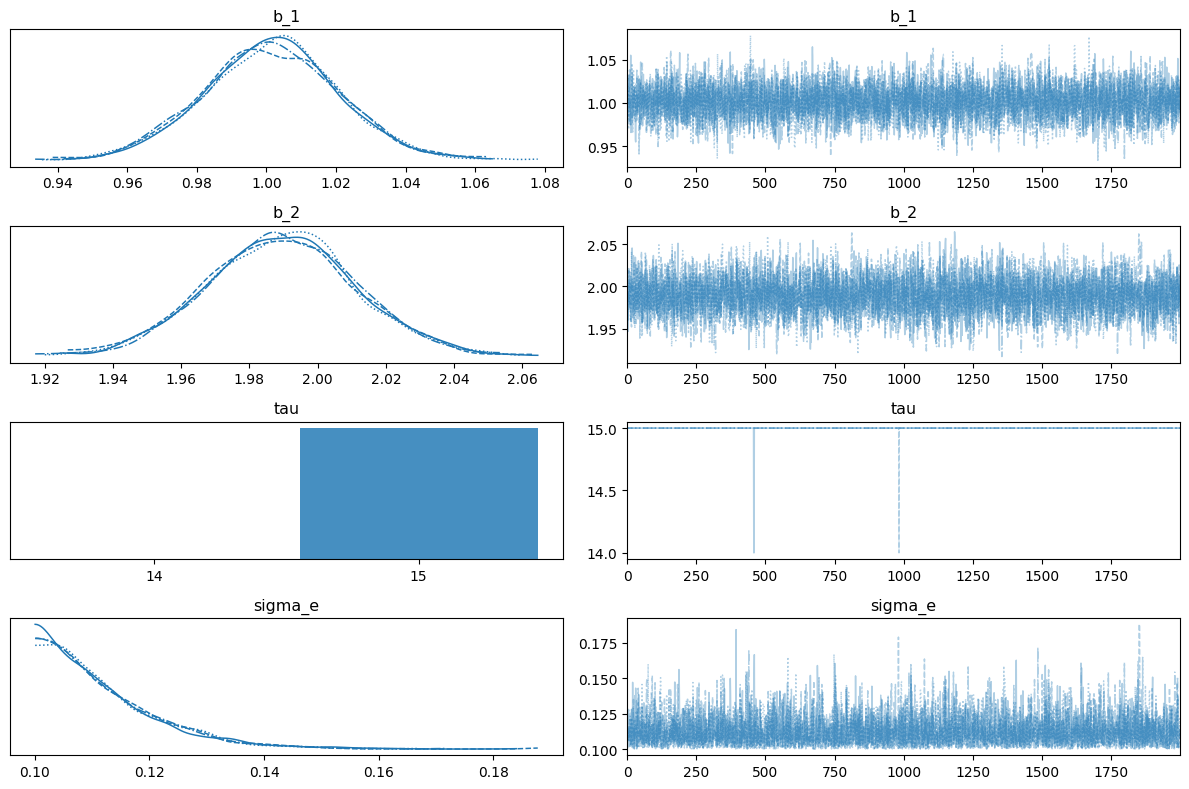

In [85]:
trace = run(rates=rates, payments=observed_payments)
summary = az.summary(trace, var_names=["b_1", "b_2", "tau", "sigma_e"])
print(summary)

az.plot_trace(trace, var_names=["b_1", "b_2", "tau", "sigma_e"])
plt.tight_layout()
plt.show()

# Noise increases
In our case it can be difference in time, during which bank calculates, updates a system or rounding NBP rate

In [86]:
# Define the TRUE part of the story
NUMBER_OF_DAYS = 30
TAU = 15 # This is the moment when bank secretly changed the risk factor (from honest to greedy)
B1 = 1
B2 = 5
NOISE_STD = 1

# Generate the fake data
rates, observed_payments, risk_array = generate_data(NUMBER_OF_DAYS, TAU, B1, B2, NOISE_STD)

Text(0, 0.5, 'Risk array')

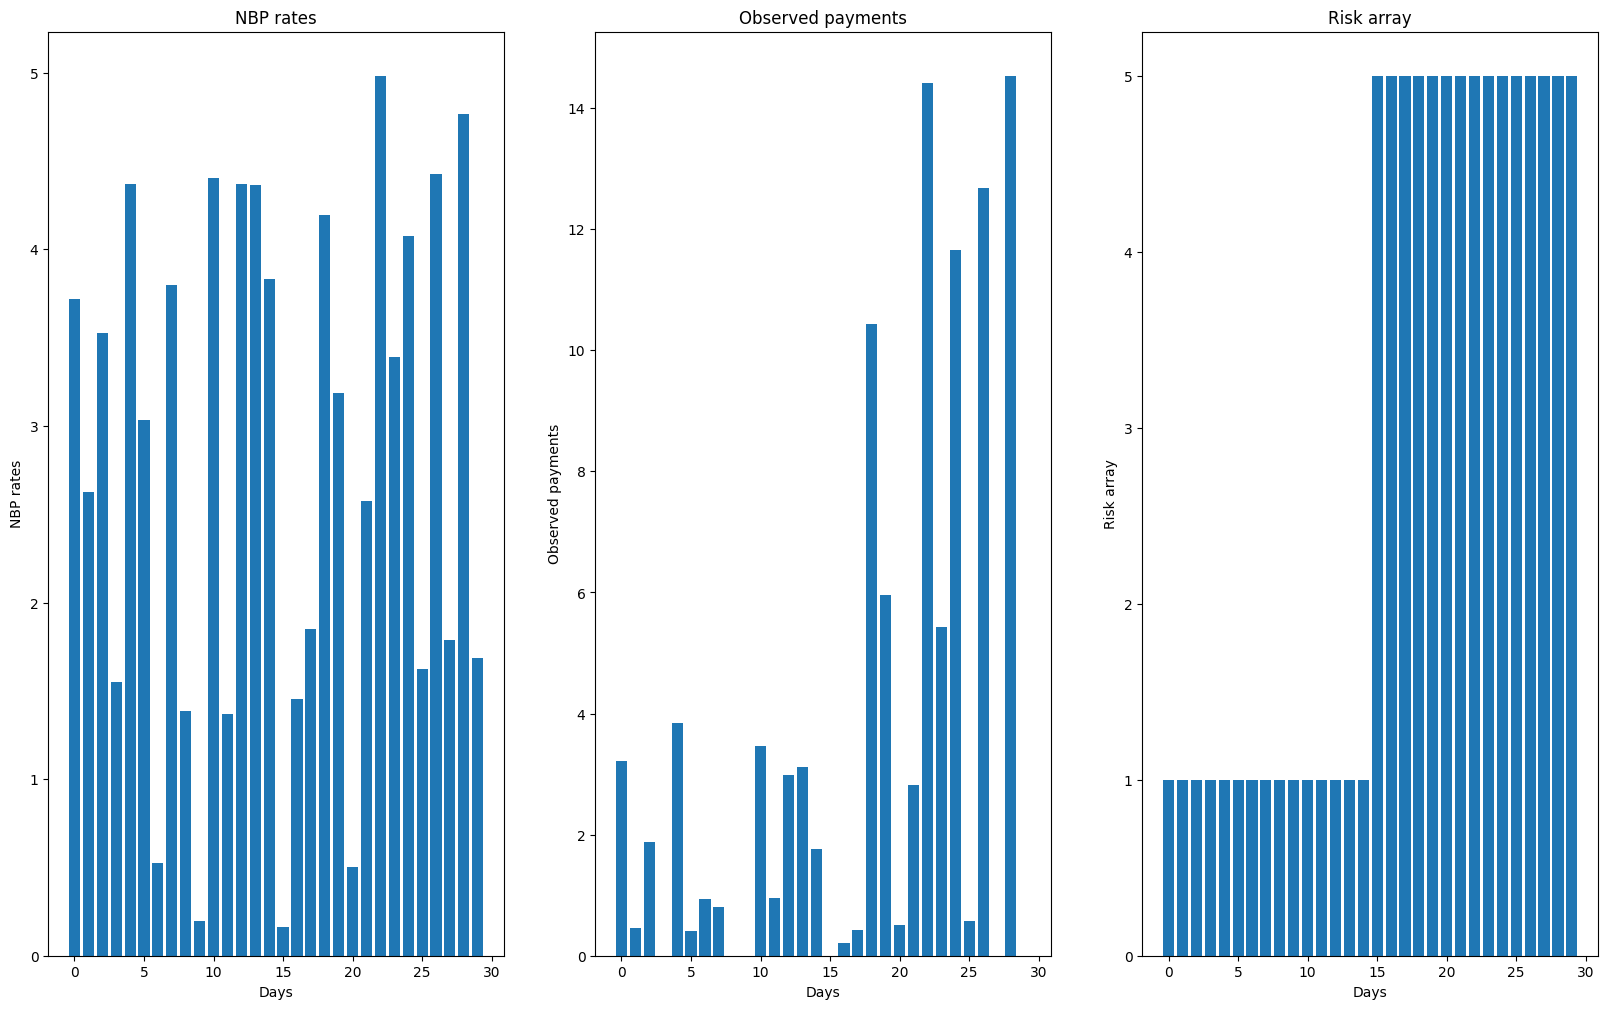

In [87]:
days = np.arange(NUMBER_OF_DAYS)
fig, ax = plt.subplots(1, 3, figsize=(20, 12))

ax[0].bar(days, rates, label="NBP rates")
ax[0].set_title("NBP rates")
ax[0].set_xlabel("Days")
ax[0].set_ylabel("NBP rates")

ax[1].bar(days, observed_payments, label="Observed payments")
ax[1].set_title("Observed payments")
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Observed payments")

ax[2].bar(days, risk_array, label="Risk array")
ax[2].set_title("Risk array")
ax[2].set_xlabel("Days")
ax[2].set_ylabel("Risk array")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_1, b_2, sigma_e]
>Metropolis: [tau]


Output()

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 144 seconds.


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_1       1.270  0.119   1.046    1.491      0.001    0.001    9441.0   
b_2       5.034  0.122   4.804    5.264      0.001    0.002    9072.0   
tau      16.463  1.112  15.000   18.000      0.027    0.010    1705.0   
sigma_e   0.719  0.103   0.548    0.920      0.001    0.001    8265.0   

         ess_tail  r_hat  
b_1        5843.0    1.0  
b_2        5532.0    1.0  
tau        1867.0    1.0  
sigma_e    5474.0    1.0  


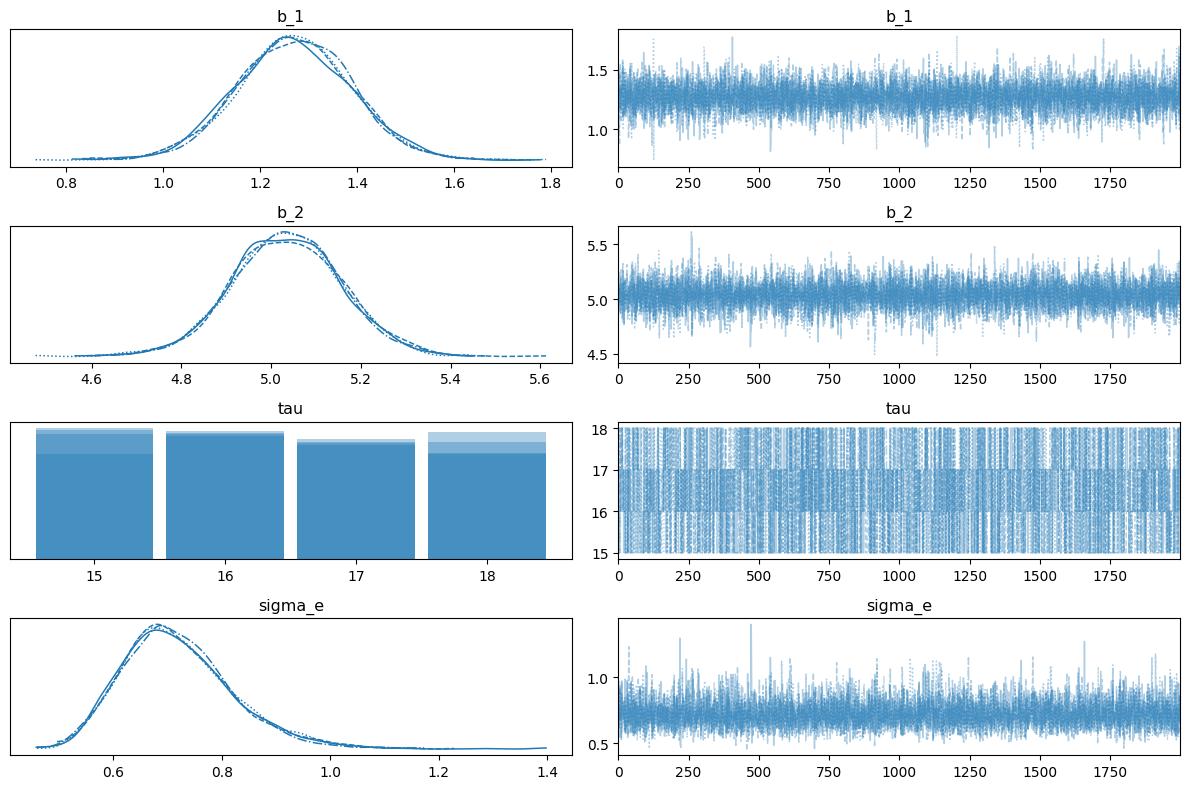

In [88]:
trace = run(rates=rates, payments=observed_payments)
summary = az.summary(trace, var_names=["b_1", "b_2", "tau", "sigma_e"])
print(summary)

az.plot_trace(trace, var_names=["b_1", "b_2", "tau", "sigma_e"])
plt.tight_layout()
plt.show()

Increasing noise caused model was not sure when the moment of switching occurs.

# The switch occurs more gradually
So bank doesn't want to be rapid with changes so customer will say 'its matter of economy, inflation"

In [89]:
# Define the TRUE part of the story
NUMBER_OF_DAYS = 30
TAU = 15 # This is the moment when bank secretly changed the risk factor (from honest to greedy)
B1 = 1
B2 = 5
NOISE_STD = 0.1
GRADUAL_WEIGHT = 2.5

# Generate the fake data
rates, observed_payments, risk_array = generate_data(NUMBER_OF_DAYS, TAU, B1, B2, NOISE_STD, GRADUAL_WEIGHT)

Text(0, 0.5, 'Risk array')

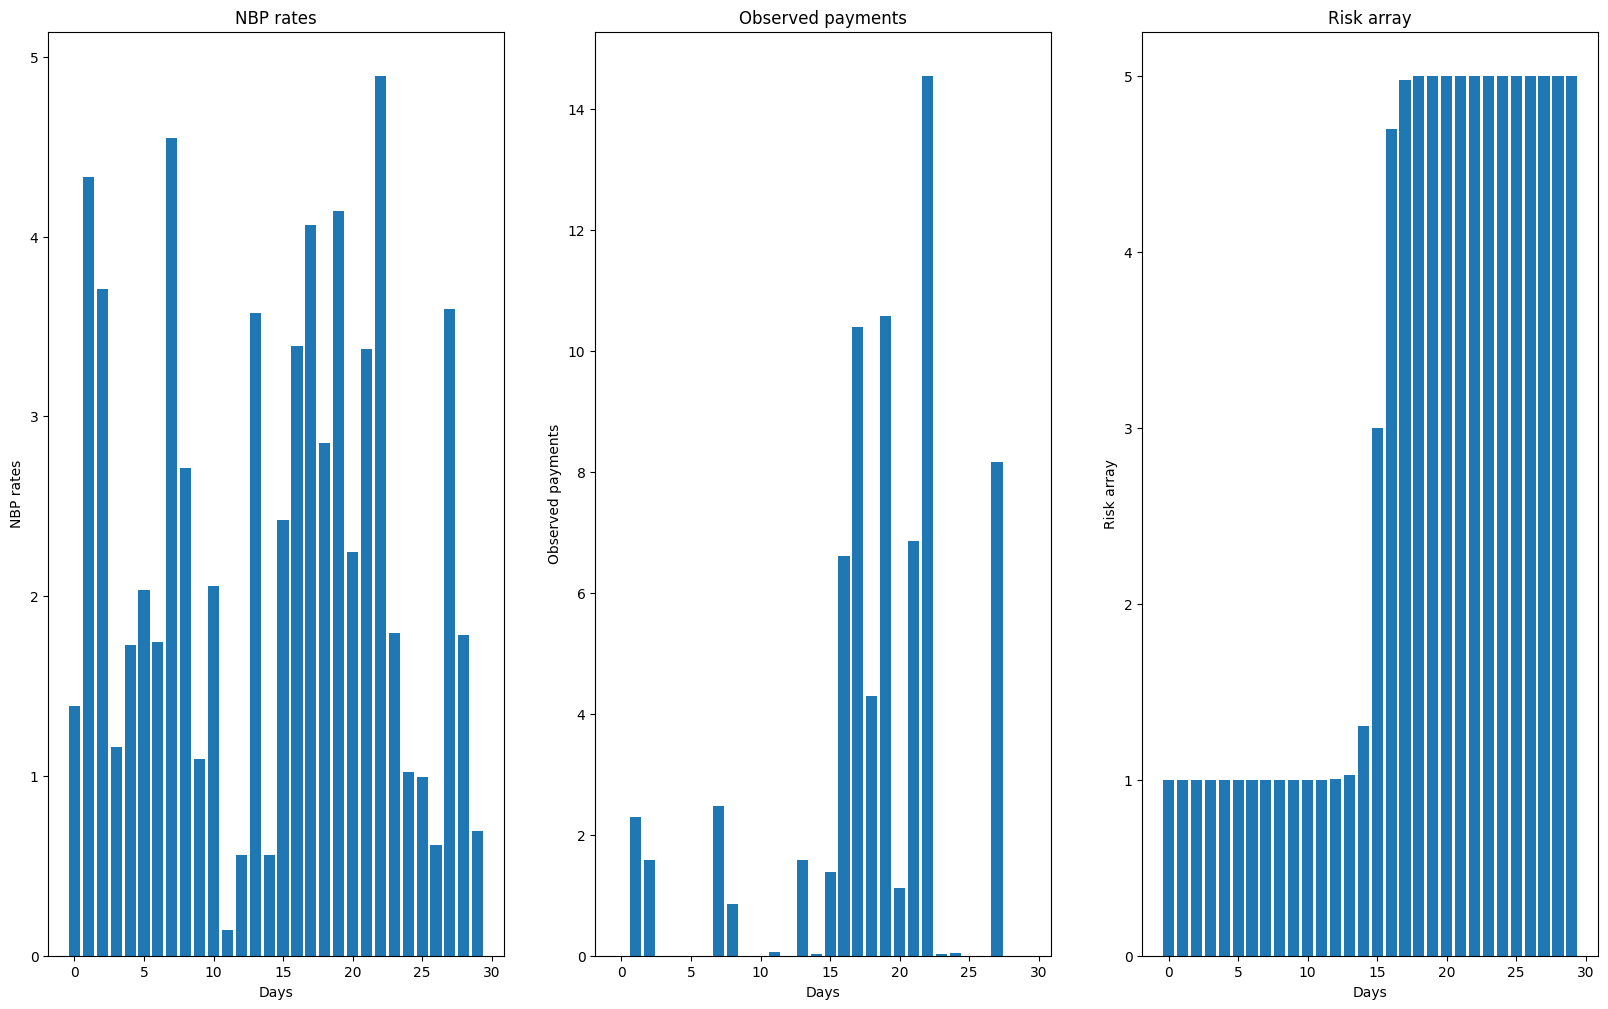

In [90]:
days = np.arange(NUMBER_OF_DAYS)
fig, ax = plt.subplots(1, 3, figsize=(20, 12))

ax[0].bar(days, rates, label="NBP rates")
ax[0].set_title("NBP rates")
ax[0].set_xlabel("Days")
ax[0].set_ylabel("NBP rates")

ax[1].bar(days, observed_payments, label="Observed payments")
ax[1].set_title("Observed payments")
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Observed payments")

ax[2].bar(days, risk_array, label="Risk array")
ax[2].set_title("Risk array")
ax[2].set_xlabel("Days")
ax[2].set_ylabel("Risk array")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b_1, b_2, sigma_e]
>Metropolis: [tau]


Output()

Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 142 seconds.


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_1       0.978  0.042   0.896    1.055      0.000    0.001   10027.0   
b_2       4.982  0.035   4.917    5.049      0.000    0.000   10154.0   
tau      14.525  0.502  14.000   15.000      0.012    0.001    1893.0   
sigma_e   0.175  0.025   0.131    0.220      0.000    0.000    8773.0   

         ess_tail  r_hat  
b_1        5687.0    1.0  
b_2        6075.0    1.0  
tau        1889.0    1.0  
sigma_e    4811.0    1.0  


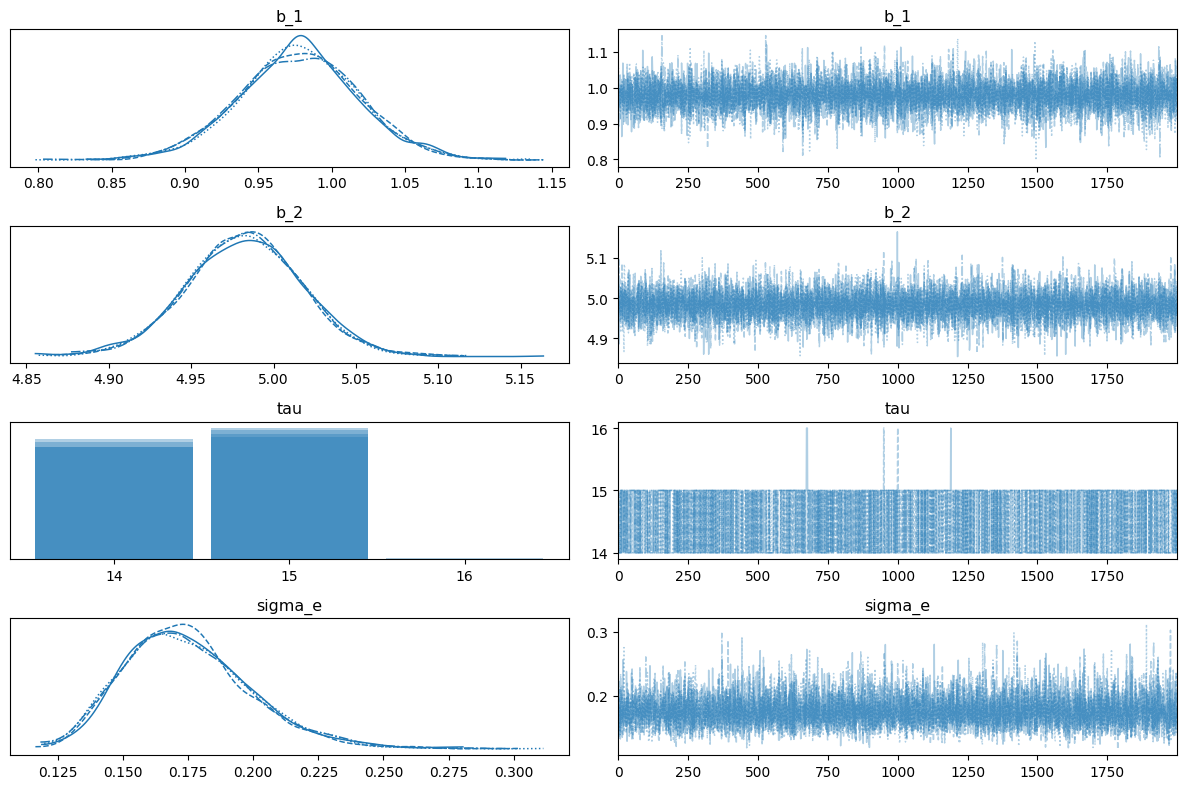

In [91]:
trace = run(rates=rates, payments=observed_payments)
summary = az.summary(trace, var_names=["b_1", "b_2", "tau", "sigma_e"])
print(summary)

az.plot_trace(trace, var_names=["b_1", "b_2", "tau", "sigma_e"])
plt.tight_layout()
plt.show()

Changing moment of switch as more gradually caused bigger noise in the model. Because in the middle of the transition true risk is 2.5 but model forces it to be either 1.0 or 5.0 so it is causing error which model takes as a noise.